# Face Recognition Project

### The contents of the notebook will be as follows:


1.   **Implementation model for Face Recognition**

    *   Dataset
    *   Building and Training a neural network
    *   Calculating Cosine Similarity

2.   **Identificaton Rate metric**


3.   **Loss functions**

    *   TripletLoss
    *   ArcFace Loss (Additive Angular Margin Loss)

## Task 1: build and train a neural network for face recognition.

### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


We will train out face recognition network on part of the CelebA dataset. But we'll use a version of it that has all the images in it aligned and cropped. Link for downloading the dataset: https://disk.yandex.ru/d/S8f03spLIA1wrw.

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
! unzip -qq celebA_train.zip

In [ ]:
!unzip -q /content/gdrive/My\ Drive/celebA_train_500.zip

Let's look at the data first:

In [ ]:
! ls celebA_train_500/

- celebA_imgs — folder with aligned images
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
from skimage import io, transform

import torch
from torch import nn
from torchsummary import summary
import torchvision
from torchvision.models import ResNeXt50_32X4D_Weights, resnext50_32x4d, resnet18
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import time
import copy
import math
import secrets
from tqdm.autonotebook import tqdm

In [ ]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Let's visualize some images to understand what we're dealing with:

Shape of images: (218, 178, 3)


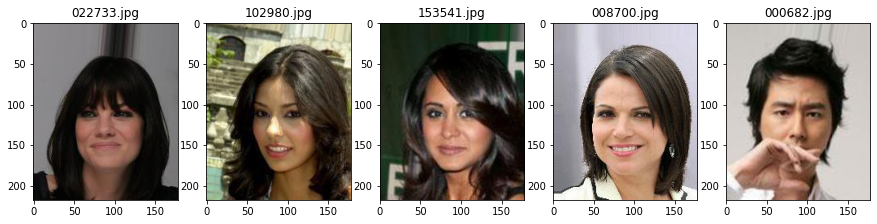

In [ ]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    print('Shape of images:', imgs[i].shape)
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [ ]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))

    return np.array(images_paths)

In [ ]:
class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        if self.aug:
            sample = {
                'image': self.aug(image),
                'label': label,
            }

        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
transform = transforms.Compose([
      transforms.Resize(300),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

aug = transforms.Compose([
     transforms.RandomCrop((200, 160)),
     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(2, 3)),
     transforms.RandomHorizontalFlip(p=1),
    #  transforms.RandomRotation(degrees=(-70, 70)),
])

In [ ]:
train_data = celebADataset('train', transform)

''' The commented code was used for augmentation,
    which was inefficient and computationally expensive.
'''
# aug_train_data = celebADataset('train', transform, aug)
# all_train_data = [train_data, aug_train_data]
# concat_train_data = torch.utils.data.ConcatDataset(all_train_data)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# train_loader = torch.utils.data.DataLoader(concat_train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_loader.dataset)

8544

In [ ]:
dataloaders_dict = {'train': train_loader,
                    'val': val_loader}
phases = ['train', 'val']

**Workflow**: train a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training.

You may use whatever model you want, including pre-trained on ImageNet models from torchvision. Please note, that **it is not allowed to use pre-trained models on any other dataset except ImageNet**.

Hints: Do not use too big model. Small ResNet-like network is enough to get the required score. Use at least 2 linear layers on the bottom. You'll need to drop the last layer after training and get image embeddings from the pre-last layer. It's not required to get the embedding from linear layer though: you may get it from last convolution layer, if you want.

**Need to achieve 70% accuracy on test set**.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, phases=phases):
    from tqdm.autonotebook import tqdm
    since = time.time()
    results = {"train_loss": [], "train_acc": [],
               "vall_loss": [], "vall_acc": []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    log_template = "Epoch {ep:03d}/{epochs:03d} -> train loss: {t_loss:0.4f} | train acc: {t_acc:0.4f} | val loss {v_loss:0.4f} | val acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in phases:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for batch in dataloaders[phase]:
                    inputs, labels = batch.values()
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val':
                    results["vall_acc"].append(epoch_acc)
                    results["vall_loss"].append(epoch_loss)
                else:
                    results["train_acc"].append(epoch_acc)
                    results["train_loss"].append(epoch_loss)
            # print('LR', optimizer.param_groups[0]['lr'])
            # scheduler.step()
            pbar_outer.update(1)
            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        if len(phases) != 1:
            tqdm.write(log_template.format(ep=epoch+1, epochs=epoch+1, t_loss=results["train_loss"][-1], t_acc=results["train_acc"][-1],
                                    v_loss=results["vall_loss"][-1], v_acc=results["vall_acc"][-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [ ]:
class Model(nn.Module):
    def __init__(self, embedding_size, pretrained=True):
        super(Model, self).__init__()
        self.model = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V2) # torchvision.models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.fc = nn.Linear(embedding_size, 500)

    def forward(self, images):
        features = self.model(images)
        embedding = self.embedding(features)
        output = self.fc(embedding)
        return output

    def extract(self, images):
        features = self.model(images)
        embedding = self.embedding(features)
        return embedding

In [ ]:
model = Model(1024)

In [ ]:
for name, p in model.named_parameters():
    p.requires_grad = True

# print(model)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Send the model to GPU
model = model.to(device)

In [ ]:
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=35, phases=phases)

epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/35
----------
train Loss: 5.3082 Acc: 0.0517
val Loss: 4.1690 Acc: 0.1427

Epoch 2/35
----------
train Loss: 3.0924 Acc: 0.3007
val Loss: 3.2586 Acc: 0.2806

Epoch 3/35
----------
train Loss: 1.6249 Acc: 0.5907
val Loss: 2.7720 Acc: 0.4031

Epoch 4/35
----------
train Loss: 0.8705 Acc: 0.7643
val Loss: 2.7605 Acc: 0.4553

Epoch 5/35
----------
train Loss: 0.4816 Acc: 0.8633
val Loss: 2.1377 Acc: 0.5634

Epoch 6/35
----------
train Loss: 0.2935 Acc: 0.9149
val Loss: 2.2667 Acc: 0.5564

Epoch 7/35
----------
train Loss: 0.1901 Acc: 0.9438
val Loss: 2.0391 Acc: 0.5942

Epoch 8/35
----------
train Loss: 0.1352 Acc: 0.9597
val Loss: 1.9849 Acc: 0.6337

Epoch 9/35
----------
train Loss: 0.1040 Acc: 0.9677
val Loss: 1.9441 Acc: 0.6390

Epoch 10/35
----------
train Loss: 0.0970 Acc: 0.9721
val Loss: 1.9090 Acc: 0.6629

Epoch 11/35
----------
train Loss: 0.0491 Acc: 0.9861
val Loss: 1.8778 Acc: 0.6704

Epoch 12/35
----------
train Loss: 0.0366 Acc: 0.9895
val Loss: 1.8016 Acc: 0.6991

E

In [ ]:
best_model_wts = copy.deepcopy(model_ft.state_dict())
torch.save(best_model_wts, "w1_cl_0,77.pth")

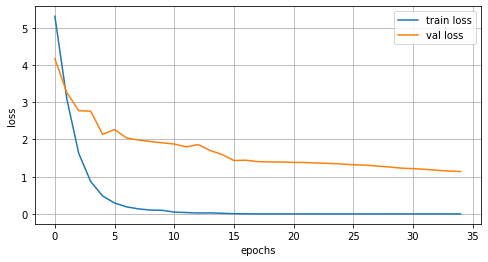

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(hist['train_loss'], label="train loss")
plt.plot(hist['vall_loss'], label="val loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

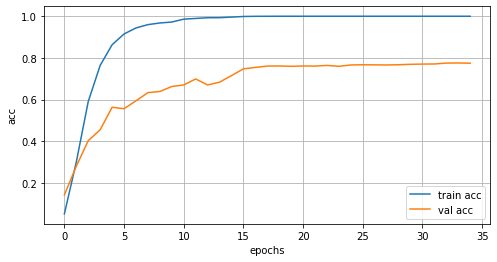

In [ ]:
hist['train_acc'] = [float(x) for x in hist['train_acc']]
hist['vall_acc'] = [float(x) for x in hist['vall_acc']]
plt.figure(figsize=(8, 4))
plt.plot(hist['train_acc'], label="train acc")
plt.plot(hist['vall_acc'], label="val acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()
plt.show()

In [ ]:
final_phase = ['val']
test_loader_dict = {'val': test_loader}

In [ ]:
_, hist_test = train_model(model_ft, test_loader_dict, criterion, optimizer, num_epochs=1, phases=final_phase)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1
----------
val Loss: 1.1695 Acc: 0.7741

Training complete in 0m 12s
Best val Acc: 0.774072


**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [ ]:
'''Load weights if necessary.'''
# model_ft = Model(1024)
# model_ft.load_state_dict(torch.load("w1_cl_0,77.pth"))
# model_ft = model_ft.to(device)

In [ ]:
emb_model = copy.deepcopy(model_ft)

In [ ]:
emb_model = emb_model.to(device)

In [ ]:
def get_emb(dataloader):
    l_labels = []
    embeddings = []
    emb_model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch.values()
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass
            output = emb_model.extract(inputs)

            embeddings.append(output.detach().cpu())
            l_labels.append(labels.data.cpu())

    return torch.cat(embeddings).numpy(), torch.cat(l_labels).numpy()

In [ ]:
train_embeddings, train_targets = get_emb(train_loader) # getting train embeddings and labels
test_embeddings, test_targets = get_emb(test_loader) # getting test embeddings and labels

In [ ]:
train_dataset_emb = pd.DataFrame({'label': train_targets, 'images_train': list(train_embeddings)},
                                 columns=['label', 'images_train']).sort_values('label').reset_index(drop=True)

test_dataset_emb = pd.DataFrame({'label': test_targets, 'images_test': list(test_embeddings)},
                                columns=['label', 'images_test']).sort_values('label').reset_index(drop=True)

In [ ]:
train_dataset_emb.head(5) # first three rows

,label,images_train
0,0,"[-0.09548251, -0.3228994, -0.83367956, -1.4717..."
1,0,"[0.11564291, -0.79601544, 0.49413788, -1.21803..."
2,0,"[0.3240823, -1.2926441, 0.59283537, -0.1681068..."
3,0,"[-0.03291537, -0.57494485, 0.8768596, -0.86926..."
4,0,"[1.1890792, -0.41379374, 0.77339643, -1.202031..."


In [ ]:
train_dataset_emb.shape

(8544, 2)

In [ ]:
def get_cos_sim(x, y=None, index=None, columns=None):
    similarity = cosine_similarity(x, y)
    return pd.DataFrame(similarity, index=index, columns=columns)

In [ ]:
train_dataset_emb['images_train'] = train_dataset_emb['images_train'].apply(lambda x: x.reshape(1, -1))
test_dataset_emb['images_test'] = test_dataset_emb['images_test'].apply(lambda x: x.reshape(1, -1))

#getting data of 10th label (just example - practically any label of 500 can be chosen)
emb_9_test = test_dataset_emb[test_dataset_emb['label']==9].reset_index(drop=True)
emb_9_train = train_dataset_emb[train_dataset_emb['label']==9].reset_index(drop=True)

In [ ]:
emb_9_train.head(3)

,label,images_train
0,9,"[[0.057585254, 0.10231727, 1.2080938, -1.12791..."
1,9,"[[0.52164644, -0.44919547, -0.3722519, -1.1111..."
2,9,"[[-0.33736524, -0.30231863, -0.06279817, -1.93..."


In [ ]:
same_cos_sim = cosine_similarity(emb_9_train.iloc[5]['images_train'],emb_9_test.iloc[0]['images_test'])
print('This is a cosine similarity for example of Same Person: ', round(same_cos_sim[0][0], 3))

This is a cosine similarity for example of Same Person:  0.865


In [ ]:
p9_train = emb_9_train['images_train'].values
p9_test = emb_9_test['images_test'].values
p9_train.shape, p9_test.shape

((21,), (4,))

In [ ]:
p9_train = emb_9_train['images_train'].values
p9_test = emb_9_test['images_test'].values
p9_train = np.array(p9_train.tolist()).reshape(21, 1024)
p9_test= np.array(p9_test.tolist()).reshape(4, 1024)
nine_label = get_cos_sim(p9_train, p9_test)

In [ ]:
emb_100_train = train_dataset_emb[train_dataset_emb['label']==27].reset_index(drop=True)
p100_train = emb_100_train['images_train'].values
p100_train = np.array(p100_train.tolist()).reshape(len(p100_train), 1024)
diff_label = get_cos_sim(p9_test,p100_train)

In [ ]:
dif_cos_sim = cosine_similarity(emb_100_train.iloc[5]['images_train'], emb_9_test.iloc[0]['images_test'])
print('This is a cosine similarity for one example of Different Persons: ', round(dif_cos_sim[0][0], 3))

This is a cosine similarity for one example of Different Persons:  0.086


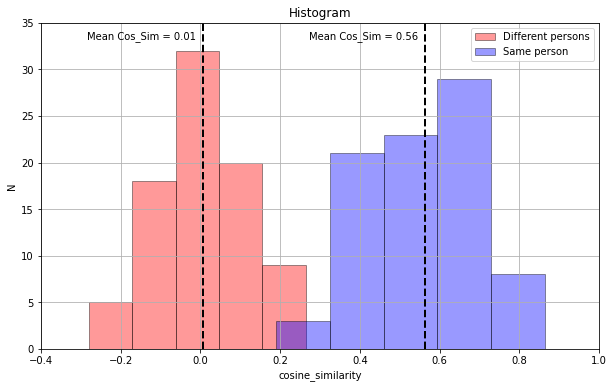

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(diff_label, hist=True, kde=False, bins=int(5), color = 'red', hist_kws={'edgecolor':'black'})
sns.distplot(nine_label, hist=True, kde=False, bins=int(5), color = 'blue', hist_kws={'edgecolor':'black'})
plt.title('Histogram')
plt.xlabel('cosine_similarity')
plt.ylabel('N')
plt.legend(('Different persons', 'Same person'), loc='upper right')
plt.xlim([-0.4, 1])
plt.ylim([0, 35])
min_ylim, max_ylim =  0, 35
plt.axvline(diff_label.mean().mean(), color='k', linestyle='dashed', linewidth=2)
plt.text(diff_label.mean().mean()-0.29, max_ylim*0.95, 'Mean Cos_Sim = {:.2f}'.format(diff_label.mean().mean()))
plt.axvline(nine_label.mean().mean(), color='k', linestyle='dashed', linewidth=2)
plt.text(nine_label.mean().mean()-0.29, max_ylim*0.95, 'Mean Cos_Sim = {:.2f}'.format(nine_label.mean().mean()))
plt.grid()

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset.

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Visualize (build histograms) the cosine similarities distributions for same and different people.

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between. For example, use 1000-5000 examples.

In [ ]:
stats_train = train_dataset_emb.groupby('label').agg(np.mean) # getting mean embedding
stats_test = test_dataset_emb.groupby('label').agg(np.mean)   # for each label | class

In [ ]:
merged = pd.merge(stats_train, stats_test, on="label")
merged = merged.reset_index()

In [ ]:
classes = len(merged['images_train'].values) # to know how many rows/classes we have in the merged df

In [ ]:
t_rain = merged['images_train'].values
t_est = merged['images_test'].values
t_rain = np.array(t_rain.tolist()).reshape(classes, 1024)
t_est = np.array(t_est.tolist()).reshape(classes, 1024)

In [ ]:
distr_cos_sim = get_cos_sim(t_rain,t_est, index = merged['label'].values,
                              columns = merged['label'].values)

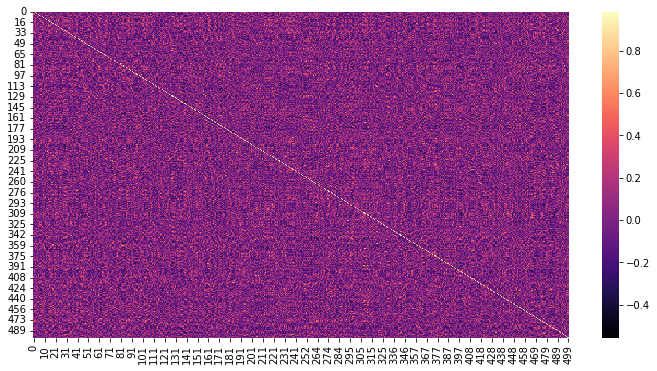

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(distr_cos_sim, cmap="magma")

The same classes are arranged on a diagonal with high similarity (white color).

## Task 2: Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos.
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset.
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary.

Datasets (query photos, query labels & distructors photos) you can download using the code below:

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
! unzip -qq celebA_ir.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 8978k  100 8978k    0     0  1497k      0  0:00:05  0:00:05 --:--:-- 2229k


In [ ]:
! ls celebA_ir/

celebA_anno_query.csv  celebA_distractors  celebA_query


In [ ]:
# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [ ]:
len(query_img_names)

1222

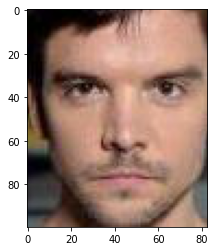

In [ ]:
query_name1 = os.listdir('celebA_ir/celebA_query/')[8]
query1 = Image.open(os.path.join('celebA_ir/celebA_query/', query_name1))
fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(query1)

**We must transform this data to the view on which the network was trained:**

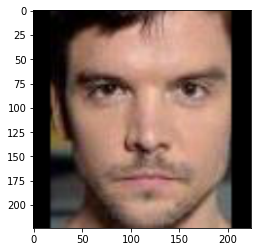

In [ ]:
query1t = transforms.CenterCrop(100)(query1)
query1tt = transforms.Resize(224)(query1t)

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(query1tt)

In [ ]:
np.array(query1tt).shape

(224, 224, 3)

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.


In [ ]:
def compute_embeddings(model, images_list):
    '''
    compute embeddings from the trained model for list of images.
    params:
      model: trained nn model that takes images and outputs embeddings
      images_list: list of images paths to compute embeddings for
    output:
      list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    '''
    transform = transforms.Compose([transforms.CenterCrop(100),
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225)),])
    embeddings = []
    model.eval()
    with torch.no_grad():
        for x in range(len(images_list)):
            img_name = images_list[x]
            if images_list == query_img_names:
                image = Image.open('celebA_ir/celebA_query/'+img_name)
            else:
                image = Image.open('celebA_ir/celebA_distractors/'+img_name)
            image = transform(image)
            image = image.to(device)
            output = model.extract(image[None, ...]) #unsqueeze(dim=0)
            embeddings.append(output.detach().cpu())

    return torch.cat(embeddings).numpy()

In [ ]:
query_embeddings = compute_embeddings(emb_model, query_img_names)
distractors_embeddings = compute_embeddings(emb_model, distractors_img_names)

In [ ]:
query_embeddings.shape, distractors_embeddings.shape

((1222, 500), (2001, 500))

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
#   compute cosine similarities between positive pairs from query (stage 1)
#   params:
#     query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
#                 the dataset. Value: images corresponding to that class
#     query_img_names: list of images names
#     query_embeddings: list of embeddings corresponding to query_img_names
#   output:
#     list of floats: similarities between embeddings corresponding
#                     to the same people from query list

    img_to_emb = dict(zip(query_img_names, query_embeddings))
    result = []
    for _, v in query_dict.items():
        for i in range(len(v)-1):
            for j in range(i+1, len(v)):
                c = cosine_similarity(np.array(img_to_emb[v[i]]).reshape(1,-1), np.array(img_to_emb[v[j]]).reshape(1,-1))
                result.append(c[0][0])
    return np.array(result)


def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
#   compute cosine similarities between negative pairs from query (stage 2)
#   params:
#     query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
#                 the dataset. Value: images corresponding to that class
#     query_img_names: list of images names
#     query_embeddings: list of embeddings corresponding to query_img_names
#   output:
#     list of floats: similarities between embeddings corresponding
#                     to different people from query list

    img_to_emb = dict(zip(query_img_names, query_embeddings))
    result = []
    keys = list(query_dict.keys())
    for i in range(len(keys)-1):
        v = query_dict[keys[i]]
        tmp = []
        for j in range(i+1, len(keys)):
            tmp.extend(query_dict[keys[j]]) # tmp = query_dict.values()[i+1:]
        for m in range(len(v)):
            for g in range(len(tmp)):
                c = cosine_similarity(
                    np.array(img_to_emb[v[m]]).reshape(1,-1),
                    np.array(img_to_emb[tmp[g]]).reshape(1,-1),
                )
                result.append(c[0][0])

    return np.array(result)

In [ ]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
#   compute cosine similarities between negative pairs from query and distractors
#   (stage 3)
#   params:
#     query_embeddings: list of embeddings corresponding to query_img_names
#     distractors_embeddings: list of embeddings corresponding to distractors_img_names
#   output:
#     list of floats: similarities between pairs of people (q, d), where q is
#                     embedding corresponding to photo from query, d —
#                     embedding corresponding to photo from distractors

    return np.array(cosine_similarity(query_embeddings, distractors_embeddings)).flatten()

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

In [ ]:
len(cosine_query_pos), len(cosine_query_neg), len(cosine_query_distractors)

(14721, 731310, 2445222)

Check you code of functions which compute similarities:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr):
#   compute identification rate using precomputer cosine similarities between pairs
#   at given fpr

#     fpr: false positive rate at which to compute TPR
#   output:
#     float: threshold for given fpr
#     float: TPR at given FPR

    false_pairs_number = len(cosine_query_neg) + len(cosine_query_distractors)
    N = int(fpr * false_pairs_number) # the number of false positives
                                      #we would allow our model to make
    false_pairs = np.concatenate([cosine_query_neg, cosine_query_distractors])
    false_pair = np.sort(false_pairs)[::-1]
    threshold = false_pair[N]
    cosine_query_pos = np.array(cosine_query_pos)
    TPR = len(cosine_query_pos[cosine_query_pos >= threshold]) / len(cosine_query_pos)
    return threshold, TPR

Check yourself:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

FPR = 0.0 --> TPR = 0.0
FPR = 0.05 --> TPR = 0.505
FPR = 0.1 --> TPR = 0.633
FPR = 0.15 --> TPR = 0.714
FPR = 0.2 --> TPR = 0.77
FPR = 0.25 --> TPR = 0.813
FPR = 0.3 --> TPR = 0.844
FPR = 0.35 --> TPR = 0.873
FPR = 0.4 --> TPR = 0.895
FPR = 0.45 --> TPR = 0.915
FPR = 0.5 --> TPR = 0.933


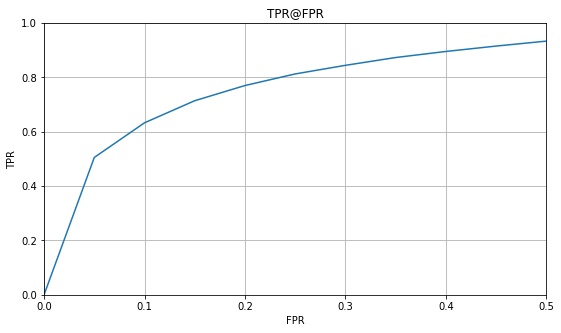

In [ ]:
tpr = []
for i in np.arange(0, .55, 0.05):
    tpr.append(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, i)[1])
    print('FPR =', round(i, 2), '--> TPR =', round(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, i)[1], 3))
plt.figure(figsize=(9,5))
plt.plot(np.arange(0, 0.55, 0.05), fpr)
plt.title('TPR@FPR')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0, 1])
plt.xlim([0, 0.5])
plt.grid()

## Task 3: Loss functions

### TripletLoss

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other.

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo.

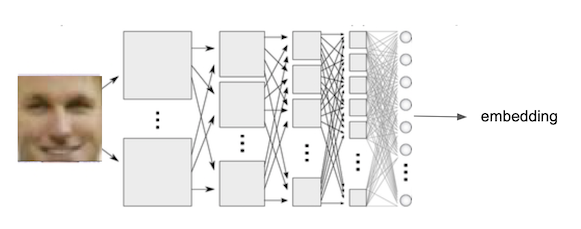

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

Which loss among which you have tried is the best?

**Need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embeddings from val and test sets calculate cosine similarities be

In [ ]:
f = open('celebA_train_500/celebA_anno.txt', 'r')
class_lines = f.readlines()
f.close()
class_lines = [x.strip().split() for x in class_lines]
class_img_names = [x[0] for x in class_lines]
# dictionary with info of which images belong to which class
# format: {class: [image_1, image_2, ...]}
class_dict = defaultdict(list)
for img_name, img_class in class_lines:
    class_dict[img_class].append(img_name)

In [ ]:
class celebADatasetTriplet(Dataset):
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)
        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_name)
        label = int(label)

        if self.aug:
            sample = self.aug(
                image)

        image = self.transform(image)
        sample = (image, int(label))

        return sample

In [ ]:
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
      transforms.Resize(300),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

To achieve an acceptable result, we will increase a batch_sise to 256.

In [ ]:
train_data_trip = celebADatasetTriplet('train', transform)
val_data_trip = celebADatasetTriplet('val', transform)
test_data_trip = celebADatasetTriplet('test', transform)

# choose your own batch_size
batch_size = 256
train_loader_trip = torch.utils.data.DataLoader(train_data_trip, batch_size=batch_size, shuffle=True)
val_loader_trip = torch.utils.data.DataLoader(val_data_trip, batch_size=batch_size, shuffle=False)
test_loader_trip = torch.utils.data.DataLoader(test_data_trip, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_loader_trip)

34

In [ ]:
dataloaders_dict_trip = {'train': train_loader_trip,
                         'val': val_loader_trip}
phases = ['train', 'val']

In order to achieve the desired result, **HardTripletLoss** was implemented. This technique allows to get useful triplets on the fly, for each batch of inputs. By most useful triplets, it means the hardest positive and the hardest negative for an anchor. To get them we begin with a computing of the pairwise distance matrix (BxB size). For the hardest positive, we take the maximum distance over each row of this distance matrix of the valid pairs (a ≠ p and a, p have same labels). For the hardest negative, we need to get the minimum distance for each row (a and n have different labels).

In [ ]:
import torch.nn as nn

class batchHardTripletLoss(nn.Module):
    def __init__(self, margin = 0.2, squared = False, agg = "mean"):
        """
        Initialize the loss function with a margin parameter, whether or not to consider
        squared Euclidean distance and how to aggregate the loss in a batch
        """
        super(batchHardTripletLoss, self).__init__()
        self.margin = margin
        self.squared = squared
        self.agg = agg
        self.eps = 1e-8

    def get_pairwise_distances(self, feat_vecs):
        """
        Computing distance for every pair using
        (a - b) ^ 2 = a^2 - 2ab + b^2
        """
        ab = feat_vecs.mm(feat_vecs.t())
        a_squared = ab.diag().unsqueeze(1)
        b_squared = ab.diag().unsqueeze(0)
        distances = a_squared - 2 * ab + b_squared
        distances = nn.ReLU()(distances)

        if not self.squared:
            distances = torch.sqrt(distances + self.eps)

        return distances


    def get_mask(self, labels, type_ = "positive"):
        """
        Get a binary matrix corresponding to valid duplet pairs for
        (anchor, positive) & (anchor, negative) pairs
        """
        DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        PK = len(labels)
        mask = torch.zeros(PK, PK).to(DEVICE)

        for idx, item in enumerate(labels):
            for inner_idx, inner_item in enumerate(labels):

                if type_ == "positive":

                    # Labels should match and the image index shouldn't be the same
                    if (item == inner_item) and (idx != inner_idx):
                        mask[idx, inner_idx] = 1
                elif type_ == "negative":

                    # Labels must be different and image index shouldn't be the same (redundant but still...)
                    if (item != inner_item) and (idx != inner_idx):
                        mask[idx, inner_idx] = 1

        return mask

    def forward(self, feat_vecs, labels):
        """
        Define the loss function implementation here
        """
        DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

        # Get the pairwise distances of all images from one another
        distances = self.get_pairwise_distances(feat_vecs).to(DEVICE)

        # Get the toughest positive pair by first filtering out the (anchor, positive)
        # pairs using the get_mask routine and then find the max across rows
        positive_mask = self.get_mask(labels, type_ = "positive").to(DEVICE)
        toughest_positive_distance = (distances * positive_mask).max(dim = 1)[0]

        negative_mask = self.get_mask(labels, type_ = "negative").to(DEVICE)

        # Add the maxiumum negative distance to all the non-valid pairs
        # on a rowwise basis and then out of them whichever is the minimum
        # will be our pair distance corresponding to toughest (anchor, negative) pair
        max_negative_dist = distances.max(dim=1,keepdim=True)[0]
        distances = distances + max_negative_dist * (1 - negative_mask).float()
        toughest_negative_distance = distances.min(dim = 1)[0]

        # Find the triplet loss by using the two distances obtained above
        triplet_loss = nn.ReLU()(toughest_positive_distance - toughest_negative_distance + self.margin)

        # Aggregate the loss to mean/sum based on the initialization of the loss function
        if self.agg == "mean":
            triplet_loss = triplet_loss.mean()
        elif self.agg == "sum":
            triplet_loss = triplet_loss.sum()

        return triplet_loss

In [ ]:
class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        print(track_str + loss_str + '   ')

In [ ]:
def train_model_trip(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25, phases=phases):
    from tqdm.autonotebook import tqdm
    results = {"train_loss": [],  "true_acc": [],
               "vall_loss": [] #, "vall_acc": []
}
    best_acc = 0.0
    log_template = "Epoch {ep:03d}/{epochs:03d} -> train loss: {t_loss:0.4f} | train acc: {t_acc:0.4f} | val loss {v_loss:0.4f} | val acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)
            # Each epoch has a training and validation phase
            for phase in phases:
                logger = Logger(phase, length=len(dataloaders[phase]), calculate_mean=True)
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0
                embeddings, l_labels = [], []
                for i_batch, (x, labels) in enumerate(dataloaders[phase]):
                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        anchor = model(x.cuda()).cpu()
                        loss = criterion(anchor, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            optimizer.zero_grad()
                    # statistics
                    loss = loss.detach().cpu()
                    running_loss += loss.item()

                logger(running_loss, i_batch)
                running_loss = running_loss/(i_batch + 1)

                if phase == 'val':
                    # results["vall_acc"].append(val_acc)
                    results["vall_loss"].append(running_loss)
                else:
                #     results["train_acc"].append(epoch_acc)
                    results["train_loss"].append(running_loss)

            if (epoch+1) % 2 == 0 or (epoch+1)>40:
                train_embs_trip, train_targets_trip = get_emb(train_loader_trip, model)
                val_embs_trip, val_targets_trip = get_emb(val_loader_trip, model)
                KNN = KNeighborsClassifier(n_neighbors=5)
                KNN.fit(train_embs_trip, train_targets_trip)
                true_acc = accuracy_score(val_targets_trip, KNN.predict(val_embs_trip))
                results["true_acc"].append(true_acc)
                print("Accuracy val:", true_acc)
                # deep copy the model
                if phase == 'val' and true_acc > best_acc:
                    best_acc = true_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            pbar_outer.update(1)
            print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

We take ResNet18 model for this task due to the CUDA memory allocation problem.

In [ ]:
trip_model = torchvision.models.resnet18(pretrained=True) #resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

num_ftrs = trip_model.fc.in_features
emb_vector_size = 512
trip_model.fc = nn.Linear(num_ftrs, emb_vector_size)

for name, p in trip_model.named_parameters():
    p.requires_grad = True

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
trip_model = trip_model.to(device)

In [ ]:
def get_emb(dataloader, model):
    l_labels = []
    embeddings = []
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0], data[1] #[3]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass
            output = model(inputs)

            embeddings.append(output.detach().cpu())
            l_labels.append(labels.data.cpu())

    return torch.cat(embeddings).numpy(), torch.cat(l_labels).numpy()

In [ ]:
optimizer = optim.SGD(trip_model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)
# criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=0.5)  # for offline embs mining

In [ ]:
criterion = batchHardTripletLoss(margin = 0.4, squared = False, agg = "mean")

In [ ]:
 import gc
torch.cuda.empty_cache()
gc.collect()

14

In [ ]:
fit_emb_model, loss_trip = train_model_trip(trip_model, dataloaders_dict_trip, criterion, optimizer, num_epochs=50, phases=phases)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
train |    34/34   | loss:    0.4831 |    
val |     8/8    | loss:    0.6436 |    

Epoch 2/50
----------
train |    34/34   | loss:    0.1992 |    
val |     8/8    | loss:    0.5122 |    
Accuracy val: 0.27103301384451545

Epoch 3/50
----------
train |    34/34   | loss:    0.1900 |    
val |     8/8    | loss:    0.4908 |    

Epoch 4/50
----------
train |    34/34   | loss:    0.1891 |    
val |     8/8    | loss:    0.4876 |    
Accuracy val: 0.37167199148029817

Epoch 5/50
----------
train |    34/34   | loss:    0.1820 |    
val |     8/8    | loss:    0.4806 |    

Epoch 6/50
----------
train |    34/34   | loss:    0.1770 |    
val |     8/8    | loss:    0.4777 |    
Accuracy val: 0.42012779552715657

Epoch 7/50
----------
train |    34/34   | loss:    0.1751 |    
val |     8/8    | loss:    0.4729 |    

Epoch 8/50
----------
train |    34/34   | loss:    0.1710 |    
val |     8/8    | loss:    0.4715 |    
Accuracy val: 0.4547390841320554

Epoch 9/5

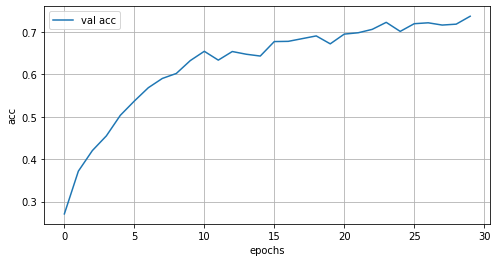

In [ ]:
loss_trip['true_acc'] = [float(x) for x in loss_trip['true_acc']]
plt.figure(figsize=(8, 4))
# plt.plot(hist['train_acc'], label="train acc")
plt.plot(loss_trip['true_acc'], label="val acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()
plt.show()

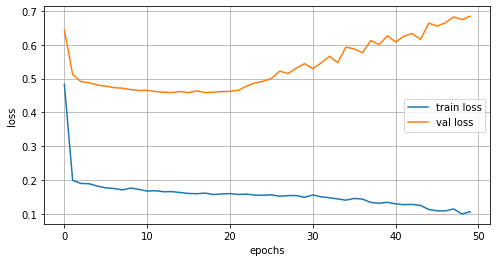

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss_trip['train_loss'], label="train loss")
plt.plot(loss_trip['vall_loss'], label="val loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

In [ ]:
fit_emb_model = fit_emb_model.to(device)

In [ ]:
fit_emb_model.train()
with torch.set_grad_enabled(True):
    wieghts_trip = copy.deepcopy(fit_emb_model.state_dict())
    torch.save(wieghts_trip, "wieghts_hard_trip0,55_m=0,5.pth")

In [ ]:
train_embs_trip, train_targets_trip = get_emb(train_loader_trip, fit_emb_model)
val_embs_trip, val_targets_trip = get_emb(val_loader_trip, fit_emb_model)
test_embs_trip, test_targets_trip = get_emb(test_loader_trip, fit_emb_model)

In [ ]:
all_embs = [[] for i in range(500)]
for i, label in enumerate(train_targets_trip):
    all_embs[int(label)].append(train_embs_trip[i])
min_emb = [np.mean(all_embs[i], axis=0) for i in range(500)]
min_emb_np = np.array(min_emb.copy())
pred_labels = np.argmax(cosine_similarity(min_emb_np, test_embs_trip), axis=0)
np.sum(pred_labels==test_targets_trip)/len(test_targets_trip)

0.7275015733165513

In [ ]:
print("Test_acc_TripletLoss by mean_embs:", accuracy_score(test_targets_trip, pred_labels))

Test_acc_TripletLoss by mean_embs: 0.7275015733165513


In [ ]:
train_embs_trip.shape, val_embs_trip.shape, test_embs_trip.shape

((8544, 512), (1878, 512), (1589, 512))

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(train_embs_trip, train_targets_trip)

KNeighborsClassifier()

In [ ]:
y_pred_v = KNN.predict(val_embs_trip)
y_pred_t = KNN.predict(test_embs_trip)

print("Val_acc_TripletLoss by KNN::", accuracy_score(val_targets_trip, y_pred_v))
print("Test_acc_TripletLoss by KNN:", accuracy_score(test_targets_trip, y_pred_t))

Val_acc_TripletLoss by KNN:: 0.7364217252396166
Test_acc_TripletLoss by KNN: 0.7300188797986155


### ArcFace Loss (Additive Angular Margin Loss)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

**Need to train a model using TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**

In [ ]:
train_data_arc = celebADatasetTriplet('train', transform)
val_data_arc = celebADatasetTriplet('val', transform)
test_data_arc = celebADatasetTriplet('test', transform)

# choose your own batch_size
batch_size = 64
train_loader_arc = torch.utils.data.DataLoader(train_data_arc, batch_size=batch_size, shuffle=True)
val_loader_arc = torch.utils.data.DataLoader(val_data_arc, batch_size=batch_size, shuffle=False)
test_loader_arc = torch.utils.data.DataLoader(test_data_arc, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_loader_arc)

134

In [ ]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0,
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [ ]:
num_classes = 500

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        x = x.unsqueeze(2).unsqueeze(3) #.view(x.shape[0], 1, 1, x.shape[1])
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
class ArcModel(nn.Module):
    def __init__(self, embedding_size, m=0.4, s=8, pretrained=True):
        super(ArcModel, self).__init__()
        self.model = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V2) # torchvision.models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.fc = ArcMarginProduct(embedding_size,
                                   out_features=num_classes,
                                   s=s,
                                   m=m,
                                   easy_margin=False,
                                   ls_eps=0.0)

    def forward(self, images, labels):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        output = self.fc(embedding, labels)
        return output

    def extract(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        return embedding

In [ ]:
Arc_model = ArcModel(512, m=0.33, s=8)

In [ ]:
for name, p in Arc_model.named_parameters():
    p.requires_grad = True

In [ ]:
Arc_model = Arc_model.to(device)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        with torch.set_grad_enabled(True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs, labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs, labels)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_loader, val_loader, model, epochs):

    history = []
    best_acc = 0.0
    log_template = 'Epoch {ep:03d}/{epochs:03d} -> train_loss: {t_loss:0.4f} | val_loss {v_loss:0.4f} | train_acc {t_acc:0.4f} | val_acc {v_acc:0.4f}'

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss()
        opt = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
        # scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.75, patience=0, threshold=0.03,
        #                                                  threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-6, verbose=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs, eta_min=0.00005)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step() #val_loss/val_acc
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, epochs=epochs, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            print('lr = ', opt.param_groups[0]['lr'])
            print()
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
fit_Arc_model, history = train(train_loader_arc, val_loader_arc, model=Arc_model, epochs=25)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001/025 -> train_loss: 8.0119 | val_loss 6.8967 | train_acc 0.0043 | val_acc 0.0176
lr =  0.0004982258077957575

Epoch 002/025 -> train_loss: 5.6516 | val_loss 5.3336 | train_acc 0.0989 | val_acc 0.1523
lr =  0.0004929312112539419

Epoch 003/025 -> train_loss: 3.4687 | val_loss 4.0646 | train_acc 0.4229 | val_acc 0.3387
lr =  0.0004841997093248565

Epoch 004/025 -> train_loss: 1.8705 | val_loss 3.6038 | train_acc 0.7471 | val_acc 0.4531
lr =  0.00047216900300986925

Epoch 005/025 -> train_loss: 0.9831 | val_loss 2.8687 | train_acc 0.9266 | val_acc 0.5831
lr =  0.00045702882373436317

Epoch 006/025 -> train_loss: 0.5909 | val_loss 2.6233 | train_acc 0.9826 | val_acc 0.6384
lr =  0.0004390179411698176

Epoch 007/025 -> train_loss: 0.4308 | val_loss 2.4035 | train_acc 0.9926 | val_acc 0.6715
lr =  0.0004184203976934552

Epoch 008/025 -> train_loss: 0.3591 | val_loss 2.3198 | train_acc 0.9979 | val_acc 0.6970
lr =  0.0003955610288702742

Epoch 009/025 -> train_loss: 0.3278 | val_loss

In [ ]:
fit_Arc_model.train()
with torch.set_grad_enabled(True):
    wieghts_trip = copy.deepcopy(fit_Arc_model.state_dict())
    torch.save(wieghts_trip, "wieghts_arc_m0,33_s8.pth")

In [ ]:
arc_history = history

In [ ]:
train_loss, train_acc, val_loss, val_acc = zip(*arc_history)

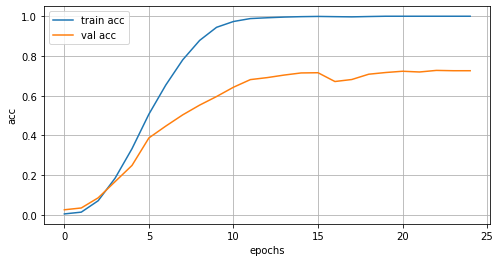

In [ ]:
train_acc_g = [x.item() for x in train_acc]
val_acc_g = [x.item() for x in val_acc]
plt.figure(figsize=(8, 4))
plt.plot(train_acc_g, label="train acc")
plt.plot(val_acc_g, label="val acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

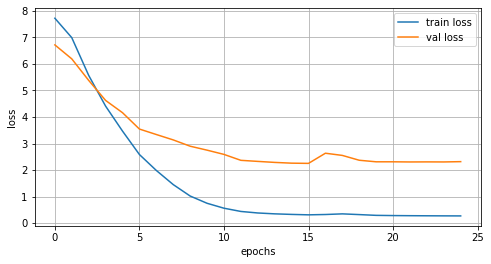

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

In [ ]:
criterion = nn.CrossEntropyLoss()
tesr_loss, test_acc = eval_epoch(fit_Arc_model, test_loader_arc, criterion)

In [ ]:
print('Arc_test_loss: ', tesr_loss)
print('Arc_test_acc: ', test_acc.item())

Arc_test_loss:  2.3330929501391267
Arc_test_acc:  0.7212083071113908
